In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import shock_tube
from fvhoe.solver import EulerSolver
from fvhoe.visualization import sample_circular_average
import matplotlib.pyplot as plt
import numpy as np
from sedov import sedovana

In [2]:
def get_analytical_solution(dim: int, gamma: float, E0: float, rho0: float, t: float):
    r, d, u, p = sedovana(gamma=gamma, dim=dim, n1=100000, n2=100000)

    r *= (E0 / rho0) ** (1 / (dim + 2)) * t ** (2 / (dim + 2))
    d *= rho0
    u *= (E0 / rho0) ** (1 / (dim + 2)) * t ** (-dim / (dim + 2))
    p *= (E0 / rho0) ** (2 / (dim + 2)) * t ** (-2 * dim / (dim + 2)) * rho0

    return r, d, u, p

In [3]:
gamma = 1.4
E0 = 1
rho0 = 1
t = 0.8

1D

chi0=0.9754065475031871


Text(0.5, 0, '$x$')

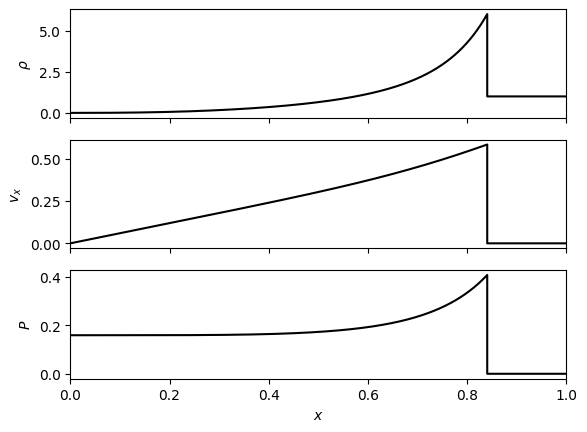

In [4]:
fig, ax = plt.subplots(3, sharex=True)

r, d, u, p = get_analytical_solution(1, gamma, E0, rho0, t)
ax[0].plot(r, d, label="Analytical", color="k")
ax[0].set_ylabel(r"$\rho$")
ax[1].plot(r, u, label="Analytical", color="k")
ax[1].set_ylabel(r"$v_x$")
ax[2].plot(r, p, label="Analytical", color="k")
ax[2].set_ylabel(r"$P$")
ax[2].set_xlim(0, 1)
ax[2].set_xlabel(r"$x$")

In [5]:
N = 128
snapshot_dir = "/scratch/gpfs/jp7427/fvhoe/snapshots/sedov_1d"
overwrite = False

for p in [0, 1]:
    solver = EulerSolver(
        w0=partial(
            shock_tube,
            mode="cube",
            x_cube=(0, 1 / N),
            rho_in_out=(rho0, rho0),
            P_in_out=(0.5 * N * E0 * (gamma - 1), 1e-5),
        ),
        gamma=gamma,
        bc=BoundaryCondition(x=("reflective", "outflow")),
        CFL=0.8,
        nx=N,
        px=p,
        riemann_solver="hllc",
        a_posteriori_slope_limiting=True,
        slope_limiter="minmod",
        NAD=1e-2,
        all_floors=True,
        snapshots_as_fv_averages=False,
        cupy=False,
    )
    solver.rkorder(t, snapshot_dir=snapshot_dir + f"_{N=}_{p=}", overwrite=overwrite)

    solver.plot_1d_slice(ax[0], param="rho", label=f"{p=}", y=0.5, z=0.5, verbose=True)
    solver.plot_1d_slice(ax[1], param="vx", label=f"{p=}", y=0.5, z=0.5, verbose=False)
    solver.plot_1d_slice(ax[2], param="P", label=f"{p=}", y=0.5, z=0.5, verbose=False)

Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_1d_N=128_p=0
t=0.8, x=[0.00390625, 0.99609375], y=0.5, z=0.5
Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_1d_N=128_p=1
t=0.8, x=[0.00390625, 0.99609375], y=0.5, z=0.5


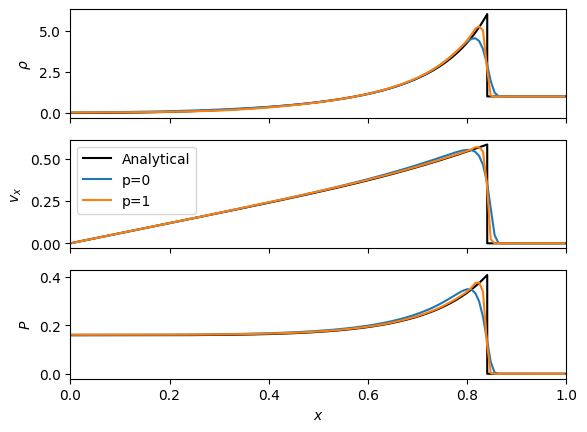

In [6]:
ax[2].set_xlim(0, 1)
ax[1].legend()
fig

2D

chi0=1.0040002436392572


Text(0.5, 0, '$x$')

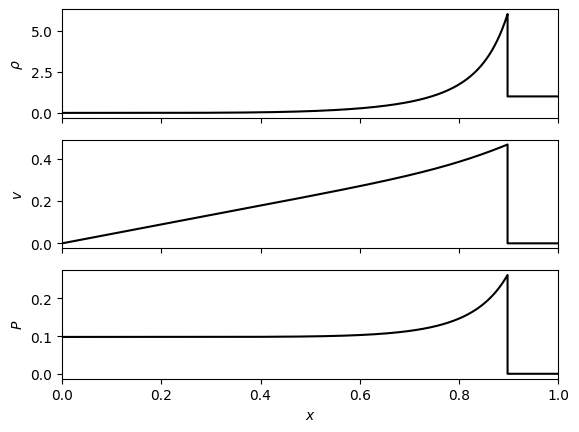

In [7]:
fig, ax = plt.subplots(3, sharex=True)

r, d, u, p = get_analytical_solution(2, gamma, E0, rho0, t)
ax[0].plot(r, d, label="Analytical", color="k")
ax[0].set_ylabel(r"$\rho$")
ax[1].plot(r, u, label="Analytical", color="k")
ax[1].set_ylabel(r"$v$")
ax[2].plot(r, p, label="Analytical", color="k")
ax[2].set_ylabel(r"$P$")
ax[2].set_xlim(0, 1)
ax[2].set_xlabel(r"$x$")

In [8]:
N = 64
snapshot_dir = "/scratch/gpfs/jp7427/fvhoe/snapshots/sedov_2d"
overwrite = False
radii = np.linspace(0, 1, N // 2 + 1)

for p in [0, 1, 3]:
    solver = EulerSolver(
        w0=partial(
            shock_tube,
            mode="cube",
            x_cube=(0, 1 / N),
            y_cube=(0, 1 / N),
            rho_in_out=(rho0, rho0),
            P_in_out=(0.25 * (N**2) * E0 * (gamma - 1), 1e-5),
        ),
        gamma=gamma,
        bc=BoundaryCondition(x=("reflective", "outflow"), y=("reflective", "outflow")),
        CFL=0.8,
        nx=N,
        ny=N,
        px=p,
        py=p,
        riemann_solver="hllc",
        a_posteriori_slope_limiting=True,
        slope_limiter="minmod",
        NAD=1e-3,
        all_floors=True,
        snapshots_as_fv_averages=False,
        cupy=True,
    )
    solver.rkorder(t, snapshot_dir=snapshot_dir + f"_{N=}_{p=}", overwrite=overwrite)

    avg_rho, avg_r = sample_circular_average(
        solver, param="rho", center=(0, 0, 0.5), radii=radii
    )
    avg_v, _ = sample_circular_average(
        solver, param="v", center=(0, 0, 0.5), radii=radii
    )
    avg_P, _ = sample_circular_average(
        solver, param="P", center=(0, 0, 0.5), radii=radii
    )
    ax[0].plot(avg_r, avg_rho, label=f"{p=}", linestyle="none", marker="*")
    ax[1].plot(avg_r, avg_v, label=f"{p=}", linestyle="none", marker="*")
    ax[2].plot(avg_r, avg_P, label=f"{p=}", linestyle="none", marker="*")

Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_2d_N=64_p=0
Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_2d_N=64_p=1
Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_2d_N=64_p=3


In [9]:
r, d, u, p = get_analytical_solution(2, gamma, E0, rho0, t)

ana_avg_r = np.empty_like(radii[:-1])
ana_avg_rho = np.empty_like(radii[:-1])
ana_avg_P = np.empty_like(radii[:-1])
ana_avg_v = np.empty_like(radii[:-1])

for i, (little_r, big_r) in enumerate(zip(radii[:-1], radii[1:])):
    inside_bin = np.logical_and(r > little_r * little_r, r <= big_r * big_r)
    sample_n = np.sum(np.where(inside_bin, 1, 0))
    r_sum = np.sum(np.where(inside_bin, r, 0))
    d_sum = np.sum(np.where(inside_bin, d, 0))
    u_sum = np.sum(np.where(inside_bin, u, 0))
    p_sum = np.sum(np.where(inside_bin, p, 0))
    ana_avg_r[i] = r_sum / sample_n if sample_n > 0 else np.nan
    ana_avg_rho[i] = d_sum / sample_n if sample_n > 0 else np.nan
    ana_avg_P[i] = p_sum / sample_n if sample_n > 0 else np.nan
    ana_avg_v[i] = u_sum / sample_n if sample_n > 0 else np.nan

ax[0].plot(ana_avg_r, ana_avg_rho, label=f"{p=}", linestyle="none", marker="*")
ax[1].plot(ana_avg_r, ana_avg_v, label=f"{p=}", linestyle="none", marker="*")
ax[2].plot(ana_avg_r, ana_avg_P, label=f"{p=}", linestyle="none", marker="*")

chi0=1.0040002436392572


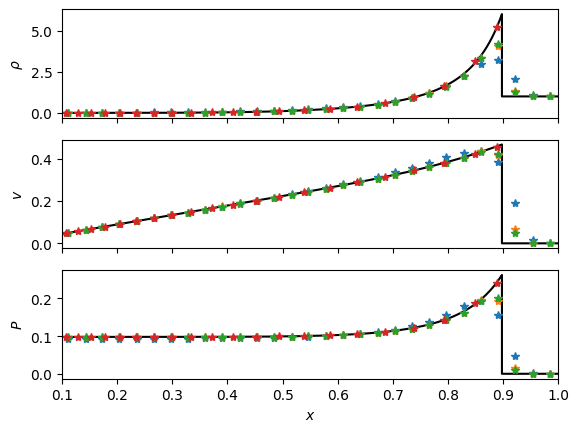

In [10]:
ax[2].set_xlim(0.1, 1)
fig

t=0.8, x=[0.0078125, 0.9921875], y=[0.0078125, 0.9921875], z=0.5
horizontal_axis='x', vertical_axis='y'
t=0.8, x=[0.0078125, 0.9921875], y=[0.0078125, 0.9921875], z=0.5
horizontal_axis='x', vertical_axis='y'
t=0.8, x=[0.0078125, 0.9921875], y=[0.0078125, 0.9921875], z=0.5
horizontal_axis='x', vertical_axis='y'
t=0.8, x=[0.0078125, 0.9921875], y=[0.0078125, 0.9921875], z=0.5
horizontal_axis='x', vertical_axis='y'
t=0.8, x=[0.0078125, 0.9921875], y=[0.0078125, 0.9921875], z=0.5
horizontal_axis='x', vertical_axis='y'
t=0.8, x=[0.0078125, 0.9921875], y=[0.0078125, 0.9921875], z=0.5
horizontal_axis='x', vertical_axis='y'


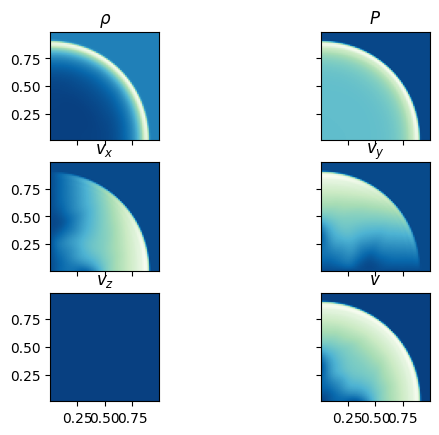

In [11]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
ax[0, 0].set_title(r"$\rho$")
solver.plot_2d_slice(ax[0, 0], param="rho", z=0)
ax[0, 1].set_title(r"$P$")
solver.plot_2d_slice(ax[0, 1], param="P", z=0)
ax[1, 0].set_title(r"$v_x$")
solver.plot_2d_slice(ax[1, 0], param="vx", z=0)
ax[1, 1].set_title(r"$v_y$")
solver.plot_2d_slice(ax[1, 1], param="vy", z=0)
ax[2, 0].set_title(r"$v_z$")
solver.plot_2d_slice(ax[2, 0], param="vz", z=0)
ax[2, 1].set_title(r"$v$")
solver.plot_2d_slice(ax[2, 1], param="v", z=0)

3D

chi0=1.032758805392732


Text(0.5, 0, '$x$')

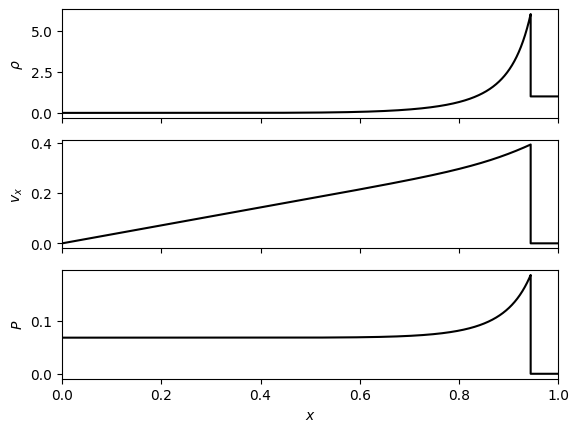

In [12]:
fig, ax = plt.subplots(3, sharex=True)

r, d, u, p = get_analytical_solution(3, gamma, E0, rho0, t)
ax[0].plot(r, d, label="Analytical", color="k")
ax[0].set_ylabel(r"$\rho$")
ax[1].plot(r, u, label="Analytical", color="k")
ax[1].set_ylabel(r"$v_x$")
ax[2].plot(r, p, label="Analytical", color="k")
ax[2].set_ylabel(r"$P$")
ax[2].set_xlim(0, 1)
ax[2].set_xlabel(r"$x$")

In [13]:
N = 64
snapshot_dir = "/scratch/gpfs/jp7427/fvhoe/snapshots/sedov_3d"
overwrite = False
radii = np.linspace(0, 1, N // 2 + 1)

for p in [0, 1]:
    solver = EulerSolver(
        w0=partial(
            shock_tube,
            mode="cube",
            x_cube=(0, 1 / N),
            y_cube=(0, 1 / N),
            z_cube=(0, 1 / N),
            rho_in_out=(rho0, rho0),
            P_in_out=(1 / 8 * (N**3) * E0 * (gamma - 1), 1e-5),
        ),
        gamma=gamma,
        bc=BoundaryCondition(
            x=("reflective", "outflow"),
            y=("reflective", "outflow"),
            z=("reflective", "outflow"),
        ),
        CFL=0.8,
        nx=N,
        ny=N,
        nz=N,
        px=p,
        py=p,
        pz=p,
        riemann_solver="llf",
        a_posteriori_slope_limiting=True,
        slope_limiter="minmod",
        NAD=1e-3,
        all_floors=True,
        snapshots_as_fv_averages=False,
        cupy=True,
    )
    solver.rkorder(t, snapshot_dir=snapshot_dir + f"_{N=}_{p=}", overwrite=overwrite)

    avg_rho, avg_r = sample_circular_average(
        solver, param="rho", center=(0, 0, 0), radii=radii
    )
    avg_v, _ = sample_circular_average(solver, param="v", center=(0, 0, 0), radii=radii)
    avg_P, _ = sample_circular_average(solver, param="P", center=(0, 0, 0), radii=radii)
    ax[0].plot(avg_r, avg_rho, label=f"{p=}", linestyle="none", marker="*")
    ax[1].plot(avg_r, avg_v, label=f"{p=}", linestyle="none", marker="*")
    ax[2].plot(avg_r, avg_P, label=f"{p=}", linestyle="none", marker="*")

Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_3d_N=64_p=0
Read from snapshot directory /scratch/gpfs/jp7427/fvhoe/snapshots/sedov_3d_N=64_p=1


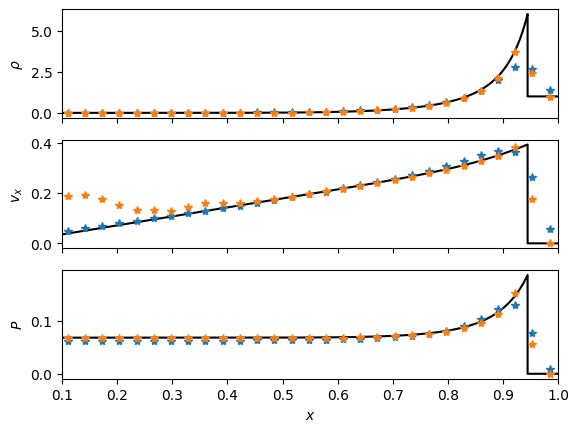

In [14]:
ax[2].set_xlim(0.1, 1)
fig

t=0.8, x=0.0078125, y=[0.0078125, 0.9921875], z=[0.0078125, 0.9921875]
horizontal_axis='y', vertical_axis='z'
t=0.8, x=0.0078125, y=[0.0078125, 0.9921875], z=[0.0078125, 0.9921875]
horizontal_axis='y', vertical_axis='z'
t=0.8, x=0.0078125, y=[0.0078125, 0.9921875], z=[0.0078125, 0.9921875]
horizontal_axis='y', vertical_axis='z'
t=0.8, x=0.0078125, y=[0.0078125, 0.9921875], z=[0.0078125, 0.9921875]
horizontal_axis='y', vertical_axis='z'
t=0.8, x=0.0078125, y=[0.0078125, 0.9921875], z=[0.0078125, 0.9921875]
horizontal_axis='y', vertical_axis='z'
t=0.8, x=0.0078125, y=[0.0078125, 0.9921875], z=[0.0078125, 0.9921875]
horizontal_axis='y', vertical_axis='z'


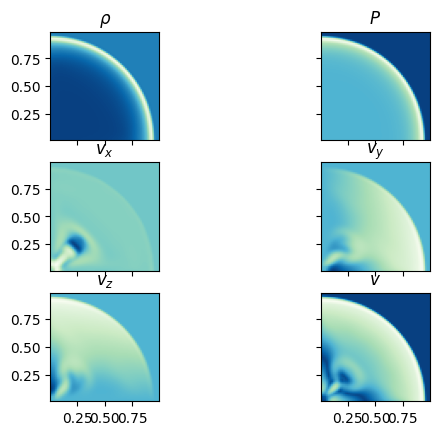

In [16]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
ax[0, 0].set_title(r"$\rho$")
solver.plot_2d_slice(ax[0, 0], param="rho", x=0)
ax[0, 1].set_title(r"$P$")
solver.plot_2d_slice(ax[0, 1], param="P", x=0)
ax[1, 0].set_title(r"$v_x$")
solver.plot_2d_slice(ax[1, 0], param="vx", x=0)
ax[1, 1].set_title(r"$v_y$")
solver.plot_2d_slice(ax[1, 1], param="vy", x=0)
ax[2, 0].set_title(r"$v_z$")
solver.plot_2d_slice(ax[2, 0], param="vz", x=0)
ax[2, 1].set_title(r"$v$")
solver.plot_2d_slice(ax[2, 1], param="v", x=0)